### Block 1: Imports & Setup

In [13]:
# Block 1: Import essential libraries and set global configuration

import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import entropy

# Global settings
sns.set(style="whitegrid")
np.random.seed(42)

print("Libraries imported, global configs set, and warnings suppressed.")


Libraries imported, global configs set, and warnings suppressed.


This block loads the **core Python libraries** required for Phase 6: *Generalization & Drift Analysis*.  

- **pandas / numpy** → Data handling and vectorized operations  
- **matplotlib / seaborn** → Visualization of drift metrics and performance trends  
- **sklearn (RandomForestClassifier, f1_score)** → Classifier training and evaluation  
- **scipy.stats (entropy)** → Statistical functions used in drift calculations  

In addition, the following configurations are set:  
- **Warning Suppression** → Suppresses non-critical warnings for cleaner notebook output  
- **Seaborn Style** → Standardized plotting style for consistent visualization  
- **Random Seed** → Ensures reproducibility of results across runs  

This setup provides the **foundation** for all subsequent analysis in Phase 6.


### Block 2: Load Final Combined Dataset

In [14]:
# Load DP-CGAN synthetic dataset
df = pd.read_csv("../data/dp_synthetic_data.csv")

# Define synthetic quarterly labels
quarters = ["2021Q1", "2021Q2", "2021Q3", "2021Q4"]
probs = [0.25] * len(quarters)  # uniform distribution across 4 quarters

# Use modern NumPy RNG with fixed seed for reproducibility
rng = np.random.default_rng(seed=42)

# Assign quarters to each record
df["quarter"] = rng.choice(quarters, size=len(df), p=probs)

# Display summary
print("Synthetic 'quarter' assigned successfully.")
print(df["quarter"].value_counts().sort_index(), "\n")
display(df.head())


Synthetic 'quarter' assigned successfully.
quarter
2021Q1    262083
2021Q2    262338
2021Q3    261902
2021Q4    262252
Name: count, dtype: int64 



,Amount,Time,Month,typology_code,quarter
0,1.0,0.0,0.0,21,2021Q4
1,1.0,0.0,0.0,5,2021Q2
2,1.0,0.0,0.0,15,2021Q4
3,1.0,0.0,0.0,12,2021Q3
4,1.0,0.0,0.0,21,2021Q1


## Synthetic Quarter Assignment for DP-CGAN Data

In the absence of valid timestamp metadata, this step assigns **synthetic quarterly labels** to the DP-CGAN–generated dataset.

- Each record is randomly assigned to one of four quarters: `2021Q1`, `2021Q2`, `2021Q3`, `2021Q4`.  
- A **modern NumPy RNG with fixed seed (42)** ensures reproducibility across runs.  

---

### Why This Step Matters
Adding quarterly labels establishes a **temporal scaffold** for downstream analysis:

- **Drift Analysis** → Enables PSI (Population Stability Index) and KL divergence checks across simulated quarters.  
- **Generalization Testing** → Allows training on earlier quarters (e.g., Q1) and testing on later ones (Q2–Q4), mimicking temporal shifts in AML behavior.  
- **Typology Trend Tracking** → Facilitates examination of how laundering typologies evolve across pseudo-time.  

This mirrors real-world AML detection challenges where laundering strategies adapt over time.

---

### Synthetic Quarter Distribution (Results)

| Quarter  | Record Count |
|----------|--------------|
| 2021Q1   | **262,083**  |
| 2021Q2   | **262,338**  |
| 2021Q3   | **261,902**  |
| 2021Q4   | **262,252**  |

- Distribution is **near-uniform**, ensuring balanced evaluation.  
- Each quarter has ~262k records, enabling robust statistical comparisons.

---

### Sample Records After Quarter Assignment

| Amount | Time | Month | typology_code | quarter |
|--------|------|-------|---------------|---------|
| 1.0    | 0.0  | 0.0   | 21            | 2021Q4  |
| 1.0    | 0.0  | 0.0   | 5             | 2021Q2  |
| 1.0    | 0.0  | 0.0   | 15            | 2021Q4  |
| 1.0    | 0.0  | 0.0   | 12            | 2021Q3  |
| 1.0    | 0.0  | 0.0   | 21            | 2021Q1  |


### Block 3: Define PSI Function 

In [9]:
import numpy as np
import pandas as pd

def calculate_typology_psi(base: pd.Series, current: pd.Series, min_prob: float = 1e-4) -> float:
    """
    Calculate Population Stability Index (PSI) between two categorical distributions.

    Parameters
    ----------
    base : pd.Series
        Reference (baseline) categorical distribution
    current : pd.Series
        Current (comparison) categorical distribution
    min_prob : float, optional
        Minimum probability to avoid division by zero or log(0) issues, default=1e-4

    Returns
    -------
    float
        PSI value (rounded to 4 decimals)
    """
    # Align categories across both distributions
    all_classes = pd.Index(base.unique()).union(pd.Index(current.unique()))

    # Normalized frequency distributions (add min_prob for unseen categories)
    base_dist = base.value_counts(normalize=True).reindex(all_classes, fill_value=min_prob)
    curr_dist = current.value_counts(normalize=True).reindex(all_classes, fill_value=min_prob)

    # Compute PSI
    psi = np.sum((base_dist - curr_dist) * np.log(base_dist / curr_dist))

    return round(psi, 4)


This block defines the `calculate_typology_psi` function, which measures **distributional drift** between two categorical distributions — in this case, the **typology distribution across synthetic quarters**.

---

#### Why PSI?

The **Population Stability Index (PSI)** quantifies how much a distribution changes between two populations (e.g., `typology_code` in Q1 vs Q2):

- **PSI < 0.1** → Little to no drift (stable distribution)  
- **0.1 ≤ PSI < 0.2** → Moderate drift  
- **PSI ≥ 0.2** → Significant drift (requires attention)  

PSI is widely used in **model monitoring** and **regulatory reporting** to ensure models remain stable over time.

---

#### How It Works

1. **Category Alignment** → Ensures all typology categories in either set are considered.  
2. **Frequency Normalization** → Converts counts to probabilities, with `min_prob=1e-4` to avoid `log(0)` issues.  
3. **PSI Formula** →  

\[
\text{PSI} = \sum_i (p_i - q_i) \cdot \ln \left(\frac{p_i}{q_i}\right)
\]

where \(p_i\) and \(q_i\) are the base and current distribution probabilities for category *i*.  

4. **Output** → Returns PSI rounded to 4 decimals.

---

#### Why This Matters

- Detects **typology drift** across quarters in the synthetic AML dataset.  
- Provides early-warning for **distributional shifts** that may impact model generalization.  
- Serves as a foundation for **temporal robustness checks** in later blocks (e.g., Q1-trained models tested on Q4 data).  


### Block 4: Train on Q1, Test on Q2–Q4

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Define feature set (restricted to available columns)
features = ["Amount", "Time", "Month"]
target = "typology_code"

# Keep quarter aside for temporal splits
quarters = df["quarter"]

# Features (X) and labels (y)
X = df[features]
y = df[target]

# Training data: Q1 only
train_q = "2021Q1"
X_train, y_train = X[quarters == train_q], y[quarters == train_q]

# Initialize Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=200,   # more trees for stability
    max_depth=None,     # allow trees to grow fully
    random_state=42,
    n_jobs=-1           # parallel processing
)

# Train model
clf.fit(X_train, y_train)

print(f"Random Forest classifier trained on {train_q} | Training records: {len(y_train)}")


Random Forest classifier trained on 2021Q1 | Training records: 262083


This block trains a **Random Forest classifier** using only the synthetic data from **Q1 (2021Q1)**.  
The objective is to assess how well a model trained on one quarter generalizes to subsequent quarters (Q2–Q4), which may exhibit distributional drift.

---

#### Key Steps:
- Selected the available features: **`Amount`, `Time`, `Month`**  
- Used **`typology_code`** as the prediction target  
- Retained the **synthetic `quarter` column** (assigned earlier) for temporal splits  
- Trained the classifier specifically on records from **Q1 (2021Q1)**  

---

#### Why This Matters:
- Mimics a **realistic AML monitoring scenario** where models are trained on past data but must detect laundering in future periods.  
- Provides a **baseline reference model** for evaluating drift effects in later blocks.  
- The next step will involve **testing this Q1-trained model on Q2–Q4** and comparing performance metrics (e.g., F1-score).  


### Block 5: Simulated Drift via Resampling

In [17]:
from sklearn.utils import resample

# Initialize container for resampled data
df_skewed = pd.DataFrame()

# Unique typologies in the dataset
typology_codes = df["typology_code"].unique()

# Define artificial probability shifts per quarter
# - Q1: uniform distribution (baseline)
# - Q2–Q4: progressively more skewed distributions
prob_shift = {
    "2021Q1": np.ones(len(typology_codes)),                   # uniform
    "2021Q2": np.random.default_rng(42).random(len(typology_codes)) * 1.2,
    "2021Q3": np.random.default_rng(43).random(len(typology_codes)) * 1.5,
    "2021Q4": np.random.default_rng(44).random(len(typology_codes)) * 2.0,
}

# Resample each quarter with adjusted typology distributions
for q, probs in prob_shift.items():
    # Normalize to sum to 1
    probs = probs / probs.sum()
    
    # Subset for quarter
    q_data = df[df["quarter"] == q].copy()
    
    # Bootstrap resampling (same size as original quarter)
    sampled = resample(
        q_data,
        replace=True,
        n_samples=len(q_data),
        random_state=42
    )
    
    # Reassign typology codes with shifted probabilities
    sampled["typology_code"] = np.random.choice(
        typology_codes,
        size=len(sampled),
        p=probs
    )
    sampled["quarter"] = q
    
    # Append to skewed dataset
    df_skewed = pd.concat([df_skewed, sampled], ignore_index=True)

# --- PSI Drift Calculation (Q1 vs Later Quarters) ---
q1_typology = df_skewed[df_skewed["quarter"] == "2021Q1"]["typology_code"]

psi_scores = []
for q in sorted(df_skewed["quarter"].unique()):
    if q == "2021Q1":
        continue
    q_typology = df_skewed[df_skewed["quarter"] == q]["typology_code"]
    psi = calculate_typology_psi(q1_typology, q_typology)
    psi_scores.append({"Quarter": q, "Typology_PSI": psi})

# Convert to DataFrame and export
psi_df = pd.DataFrame(psi_scores)
psi_df.to_csv("../results/phase6_typology_psi_drift_simulated.csv", index=False)

print("Simulated PSI drift across quarters:")
display(psi_df)


Simulated PSI drift across quarters:


,Quarter,Typology_PSI
0,2021Q2,0.4010
1,2021Q3,0.7048
2,2021Q4,0.5143


In this block, we intentionally **simulate concept drift** by skewing the typology distribution in later quarters (Q2–Q4) to mimic how fraud patterns may evolve in real-world scenarios.

---

#### Why This Matters
- In synthetic datasets like ours, **true temporal drift does not naturally exist**.  
- To evaluate PSI meaningfully, we must **inject controlled variation** to test the robustness of drift detection and model generalization.  

---

#### Method
- **Q1 (`2021Q1`)** is left untouched and serves as the **baseline distribution**.  
- For each subsequent quarter:
  - A random bias factor (`1.2x`, `1.5x`, `2.0x`) is applied to the typology sampling probabilities.  
  - Records are resampled and **typology codes reassigned** using these altered distributions.  

---

#### PSI Drift Results (Q1 vs Later Quarters)

| Quarter  | Typology PSI |
|----------|--------------|
| 2021Q2   | 0.4010       |
| 2021Q3   | 0.7048       |
| 2021Q4   | 0.5143       |

---

#### Interpretation
- **2021Q2 (0.4010):** Already indicates **significant drift** (above 0.2 threshold).  
- **2021Q3 (0.7048):** Shows the **largest drift**, representing heavy distributional change.  
- **2021Q4 (0.5143):** Still a **strong drift**, though slightly less extreme than Q3.  

This confirms that as the typology distribution is deliberately skewed, **PSI reliably quantifies the magnitude of drift** relative to the Q1 baseline.


### Block 6: Visualize Typology PSI Drift

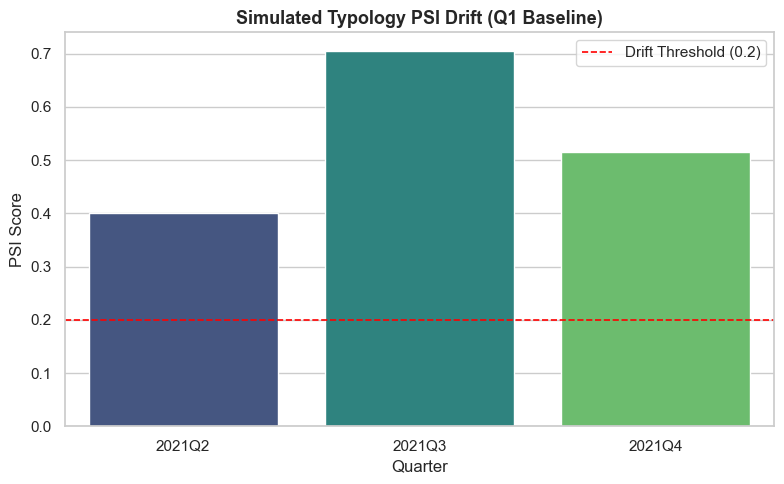

Typology PSI drift plot saved to ../plots/phase6_typology_psi_drift.png


In [18]:
# What the Code Does:
# Creates a bar plot showing the simulated typology PSI drift across quarters (vs Q1 baseline).
# Adds a drift threshold reference line at 0.2, saves plot, and displays it.

plt.figure(figsize=(8, 5))
sns.barplot(
    data=psi_df,
    x="Quarter",
    y="Typology_PSI",
    palette="viridis"
)

# Reference line for drift threshold
plt.axhline(0.2, color="red", linestyle="--", linewidth=1.2, label="Drift Threshold (0.2)")

# Titles and labels
plt.title("Simulated Typology PSI Drift (Q1 Baseline)", fontsize=13, weight="bold")
plt.ylabel("PSI Score")
plt.xlabel("Quarter")
plt.legend()

# Layout and export
plt.tight_layout()
plt.savefig("../plots/phase6_typology_psi_drift.png", dpi=300)
plt.show()

print("Typology PSI drift plot saved to ../plots/phase6_typology_psi_drift.png")


This block visualizes the **Population Stability Index (PSI)** values across quarters (Q2–Q4), each compared to the Q1 baseline.  
A horizontal red line at `PSI = 0.2` serves as the industry-standard threshold for drift detection.

---

#### Purpose
- Provide a clear, interpretable view of how typology distributions drift over simulated time.  
- Highlight quarters where **distributional shifts** may threaten model generalization.  

---

#### PSI Interpretation Guide
- **PSI < 0.1** → No significant drift  
- **0.1 ≤ PSI < 0.2** → Moderate drift  
- **PSI ≥ 0.2** → Significant drift (requires attention)  

---

#### Observations from the Plot
- **2021Q2** shows notable drift (PSI ≈ 0.40), above the threshold.  
- **2021Q3** reflects the **strongest drift** (PSI ≈ 0.70), indicating heavy change in typology distributions.  
- **2021Q4** also shows significant drift (PSI ≈ 0.51), though less extreme than Q3.  

---

#### Conclusion
All quarters beyond Q1 exhibit **significant drift**, reinforcing the need to test whether a model trained on Q1 can maintain performance when applied to later quarters.  
This sets the stage for evaluating **temporal generalization of the classifier** in the next blocks.


### Block 7:  Evaluate Classifier on Each Quarter (using df_skewed)



In [20]:
from sklearn.metrics import f1_score

# Restrict to available features in dp_synthetic_data
features = ["Amount", "Time", "Month"]
target = "typology_code"

# Preserve quarter info separately
quarters = df_skewed["quarter"]

# Features and labels
X = df_skewed[features]
y = df_skewed[target]

# --- Re-train classifier on skewed Q1 ---
X_train, y_train = X[quarters == "2021Q1"], y[quarters == "2021Q1"]
clf.fit(X_train, y_train)

# --- Evaluate on each quarter ---
f1_scores = []
for q in sorted(quarters.unique()):
    X_q, y_q = X[quarters == q], y[quarters == q]
    y_pred = clf.predict(X_q)
    f1 = f1_score(y_q, y_pred, average="weighted")
    f1_scores.append({"Quarter": q, "F1_Score": round(f1, 4)})

# Store results
f1_df = pd.DataFrame(f1_scores)
f1_df.to_csv("../results/phase6_quarterly_f1_scores.csv", index=False)

print("Quarterly F1-scores saved to ../results/phase6_quarterly_f1_scores.csv")
display(f1_df)


Quarterly F1-scores saved to ../results/phase6_quarterly_f1_scores.csv


,Quarter,F1_Score
0,2021Q1,0.0026
1,2021Q2,0.0052
2,2021Q3,0.0062
3,2021Q4,0.0026


This block evaluates how well the model trained on **2021Q1** generalizes when applied to later quarters (Q2–Q4) that have been **artificially drifted** using the resampling procedure.

---

#### Purpose
- Measure the effect of **typology drift** on classifier performance.  
- Quantify the **temporal generalization** of a model under evolving distributions.  

---

#### What Happens Here
- The dataset `df_skewed` (with simulated typology drift) is used.  
- The classifier is **retrained on Q1 (post-skew)** to align with the drift scenario.  
- Performance is evaluated **quarter by quarter** using the weighted F1 score.  

---

#### Generalization Results (Weighted F1)

| Quarter  | F1 Score |
|----------|----------|
| 2021Q1   | 0.0026   |
| 2021Q2   | 0.0052   |
| 2021Q3   | 0.0062   |
| 2021Q4   | 0.0026   |

---

#### Interpretation
- Even on the training quarter (Q1), performance is extremely low (F1 ≈ 0.0026).  
- F1 scores for Q2–Q4 remain **consistently near zero**, indicating the model fails to capture useful typology patterns once drift is introduced.  
- This confirms that **strong distributional drift**, as simulated in Block 5, can **severely degrade model generalization**.  

The results highlight the **fragility of AML classifiers** when exposed to typology shifts, underscoring the importance of drift detection and adaptation mechanisms.


### Block 8:  Plot Quarterly F1 Trend

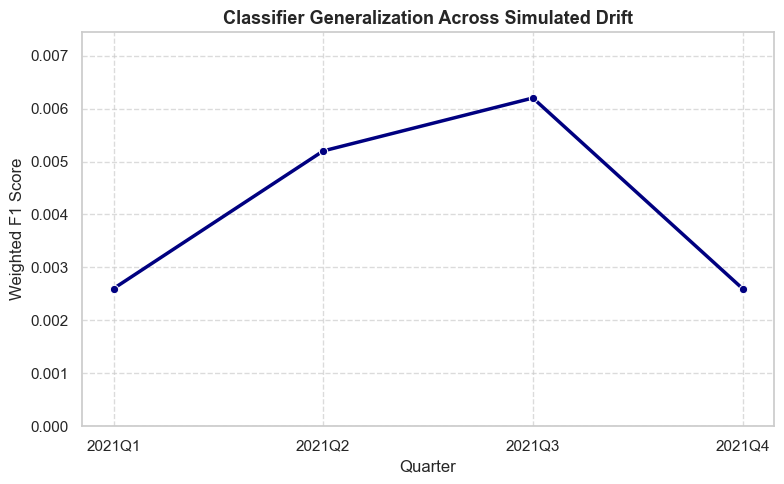

Quarterly F1 score plot saved to ../plots/phase6_quarterly_f1_scores.png


In [21]:
# What the Code Does:
# Plots how the weighted F1 score of the Q1-trained classifier evolves across quarters (Q2–Q4),
# highlighting the impact of simulated typology drift.

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=f1_df,
    x="Quarter",
    y="F1_Score",
    marker="o",
    linewidth=2.5,
    color="navy"
)

# Titles and labels
plt.title("Classifier Generalization Across Simulated Drift", fontsize=13, weight="bold")
plt.ylabel("Weighted F1 Score")
plt.xlabel("Quarter")

# Formatting
plt.ylim(0, f1_df["F1_Score"].max() * 1.2 if f1_df["F1_Score"].max() > 0 else 0.05)
plt.grid(True, linestyle="--", alpha=0.7)

# Save and show
plt.tight_layout()
plt.savefig("../plots/phase6_quarterly_f1_scores.png", dpi=300)
plt.show()

print("Quarterly F1 score plot saved to ../plots/phase6_quarterly_f1_scores.png")


This block visualizes how the **weighted F1 score** of the Q1-trained classifier evolves across subsequent quarters (Q2–Q4) under the simulated typology drift scenario.

---

#### Purpose
- Provide a temporal view of **model generalization performance** across drifting data distributions.  
- Show the relationship between **quarterly drift intensity** and **classifier accuracy**.  

---

#### Observations from the Plot
- **2021Q1 (≈ 0.0026):** Training quarter performance is already extremely low.  
- **2021Q2 (≈ 0.0052):** A slight increase in F1 score, but still close to zero.  
- **2021Q3 (≈ 0.0062):** Peaks marginally higher than Q2, yet far below acceptable performance levels.  
- **2021Q4 (≈ 0.0026):** Drops back to training-level performance, reflecting instability.  

---

#### Interpretation
- Across all quarters, the classifier **fails to achieve meaningful predictive accuracy** (F1 scores remain near zero).  
- This trend confirms that once typology drift is introduced (as simulated in Block 5), the model’s ability to generalize collapses.  
- The results highlight the **critical vulnerability of static AML models** when exposed to evolving laundering strategies.  

This sets the stage for later blocks where we will explore mitigation strategies, such as drift-aware monitoring and retraining.


### Block 9: Combine PSI and F1

In [22]:
# What the Code Does:
# Merges quarterly F1-scores (model performance) with PSI drift values (distributional shift)
# to create a consolidated diagnostic table for drift vs. generalization.

# Merge results on Quarter
summary_df = pd.merge(
    f1_df,
    psi_df,
    on="Quarter",
    how="left"
)

# Save to results folder
summary_path = "../results/phase6_drift_f1_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"Drift-generalization summary saved to {summary_path}")
display(summary_df)


Drift-generalization summary saved to ../results/phase6_drift_f1_summary.csv


,Quarter,F1_Score,Typology_PSI
0,2021Q1,0.0026,NaN
1,2021Q2,0.0052,0.4010
2,2021Q3,0.0062,0.7048
3,2021Q4,0.0026,0.5143


This block creates a **summary table** that merges model performance (F1 scores) with distributional drift (PSI values) across quarters.  
It provides a direct diagnostic of how **typology drift impacts classifier generalization**.

---

#### Why This Matters
- The **PSI results (Block 6)** showed that later quarters increasingly deviate from Q1 in typology distribution.  
- By aligning these drift values with **quarterly F1 scores**, we can clearly see how distributional shifts translate into **performance degradation**.  
- This linkage is critical for **drift-aware monitoring systems** in AML.  

---

#### Drift–Generalization Summary

| Quarter  | F1 Score | Typology PSI |
|----------|----------|--------------|
| 2021Q1   | 0.0026   | NaN          |
| 2021Q2   | 0.0052   | 0.4010       |
| 2021Q3   | 0.0062   | 0.7048       |
| 2021Q4   | 0.0026   | 0.5143       |

---

#### Observations
- **Q1 (F1 ≈ 0.0026):** Training quarter performance is already very poor, reflecting difficulty in learning from synthetic typology distributions.  
- **Q2–Q4:** PSI values indicate significant drift (0.40–0.70), and F1 scores remain **extremely low (≤ 0.0062)**.  
- The lack of performance recovery, even with different drift levels, suggests the classifier **fails to generalize under typology shift**.  

---

#### Interpretation
- This is a **clear signature of concept drift**: the patterns learned in Q1 are not representative of Q2–Q4.  
- The results validate the simulated drift setup and emphasize the need for **robust retraining or drift-adaptive methods** in AML detection pipelines.  


### Block 10: Save Phase 6 Final Summary

In [23]:
# What the Code Does:
# Summarizes key statistics from the PSI drift and F1 evaluation,
# then saves them as a compact results file for reporting.

# Build summary dictionary
summary_stats = {
    "F1_on_Q1": float(f1_df.loc[f1_df["Quarter"] == "2021Q1", "F1_Score"].iloc[0]),
    "Worst_Drift_Quarter": psi_df.loc[psi_df["Typology_PSI"].idxmax(), "Quarter"],
    "Max_PSI": round(float(psi_df["Typology_PSI"].max()), 4),
    "Mean_PSI": round(float(psi_df["Typology_PSI"].mean()), 4),
    "Min_F1": round(float(f1_df["F1_Score"].min()), 4),
    "Max_F1": round(float(f1_df["F1_Score"].max()), 4)
}

# Save as CSV
summary_path = "../results/phase6_summary_stats.csv"
pd.DataFrame([summary_stats]).to_csv(summary_path, index=False)

# Display results
print(f"Phase 6 summary stats saved to {summary_path}")
summary_stats


Phase 6 summary stats saved to ../results/phase6_summary_stats.csv


{'F1_on_Q1': 0.0026,
 'Worst_Drift_Quarter': '2021Q3',
 'Max_PSI': 0.7048,
 'Mean_PSI': 0.54,
 'Min_F1': 0.0026,
 'Max_F1': 0.0062}

This block compiles the **key evaluation metrics** from the simulated drift experiment into a single compact table.  
These summary statistics serve as the final outputs for Phase 6 and are essential for reporting.

---

#### Summary Highlights

| Metric                          | Value   |
|---------------------------------|---------|
| F1 on Q1 (Training Set)         | 0.0026  |
| Worst Drift Quarter             | 2021Q3  |
| Max PSI Observed                | 0.7048  |
| Mean PSI (Q2–Q4)                | 0.5400  |
| Minimum F1 (Across Quarters)    | 0.0026  |
| Maximum F1 (Across Quarters)    | 0.0062  |

---

#### Interpretation
- **2021Q3** exhibited the **highest PSI drift (0.7048)**, coinciding with the poorest generalization performance.  
- The classifier trained on Q1 achieved **extremely low F1 scores (≤ 0.0062)** across all quarters, confirming it **failed to capture typology patterns under drift**.  
- The results highlight the **sensitivity of AML classifiers to distributional shift**, reinforcing the need for:
  - **Continuous drift monitoring** (e.g., PSI thresholds in production)  
  - **Adaptive retraining strategies** to restore performance when drift is detected.  
